In [9]:
import trenchripper as tr
import anndata
import urllib.request
import os
import glob
import h5py
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
import colorcet as cc
import scanpy as sc
import matplotlib as mpl
import dask.dataframe as dd
import pickle as pkl
import skimage as sk

import matplotlib.pyplot as plt

## Load Data

In [5]:
min_points = 5
pos_slope_thr = 0.2
neg_slope_thr = -0.2

ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/2024-01-25_lDE20_Steady_State_df_Estimators_wStats.pkl")
ss_estimators_df = ss_estimators_df.loc["Mean (Robust)"]
all_slopes_filtered = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/Growth_Length_Slopes.csv",index_col="Gene")

In [6]:
final_columns = ["Gene","Category"]
control_categories = ['OnlyPlasmid', 'NoTarget']
params_of_interest = ['Length','Instantaneous Growth Rate: Volume']
prolif_params = []
param_names = [r"Length ($ \mu m $)",r"Volume ($ \mu m^{3} $)"]
param_ranges = [(0.,10.),(0.,2.2)]
param_ticks = [[0,2,4,6,8,10],[0.,1.,2.]]

min_n_observations = 8
## minimum set from https://stats.stackexchange.com/questions/33300/determining-sample-size-necessary-for-bootstrap-method-proposed-method
mean_frac_sem_thr = 0.2

final_column_df = ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[final_columns]
ss_estimators_df["SEM/Location"] = (np.sqrt(ss_estimators_df["Estimator Variance"])/ss_estimators_df["Value"]).copy()
ss_estimators_df = ss_estimators_df[ss_estimators_df["SEM/Location"]<mean_frac_sem_thr]
ss_estimators_df = ss_estimators_df.reset_index().set_index(["oDEPool7_id"])

##hack to get both observatoins and proliferating observations (was broken)
observation_df = ss_estimators_df[ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(ss_estimators_df[ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

variance_estimators_df = ss_estimators_df[["Variable(s)","Estimator Variance"]]
ss_estimators_df = ss_estimators_df[["Variable(s)","Value"]]
ss_estimators_df = ss_estimators_df.pivot(columns=["Variable(s)"])
variance_estimators_df = variance_estimators_df.pivot(columns=["Variable(s)"])

ss_estimators_df.columns = ss_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = variance_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = [column + " SEM" for column in variance_estimators_df.columns]
variance_estimators_df = np.sqrt(variance_estimators_df)
ss_estimators_df = ss_estimators_df.join(observation_df,on=['oDEPool7_id'])
ss_estimators_df = ss_estimators_df.join(variance_estimators_df,on=['oDEPool7_id'])

ss_estimators_df = ss_estimators_df[ss_estimators_df["N Observations"]>=min_n_observations]
ss_estimators_df["Instantaneous Growth Rate: Volume"] = ss_estimators_df["Instantaneous Growth Rate: Volume"]/np.log(2)
ss_estimators_df["Instantaneous Growth Rate: Volume SEM"] = ss_estimators_df["Instantaneous Growth Rate: Volume SEM"]/np.log(2)
ss_estimators_df = ss_estimators_df.join(final_column_df)
ss_estimators_df = ss_estimators_df.dropna(subset=params_of_interest)

# ##removing controls
ss_estimators_df_controls_only = ss_estimators_df[ss_estimators_df["Category"].isin(control_categories)]
ss_estimators_df = ss_estimators_df[~ss_estimators_df["Category"].isin(control_categories)]

filtered_ss_estimators_df = ss_estimators_df[ss_estimators_df["Gene"].isin(all_slopes_filtered.index.tolist())]

## Figure S8A

In [19]:
lipid_non_polar = ['accA','accB','accC','accD','acpP','acpS','fabH','fabD','fabG','fabI','fabB','fabA','fabZ',\
                  'plsB','plsC','cdsA','pssA','psd','pgsA','pgpB']
lipid_non_polar_operons = {"AccB-AccC":("accB","accC"),"FabH-FabD-FabG":("fabH","fabD","fabG"),\
                            "AcpP-FabF":("acpP",)}
lipid_non_polar_operons_inv = {item: key for key,val in lipid_non_polar_operons.items() for item in val}

lipid_estimators_df = ss_estimators_df[ss_estimators_df["Gene"].isin(lipid_non_polar)]
lipid_estimators_df["Gene"] = lipid_estimators_df["Gene"].apply(lambda x: lipid_non_polar_operons_inv[x] if x in lipid_non_polar_operons_inv.keys() else x)
target_gene_list = list(lipid_estimators_df["Gene"].unique())

/tmp/ipykernel_24482/1570097248.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_estimators_df["Gene"] = lipid_estimators_df["Gene"].apply(lambda x: lipid_non_polar_operons_inv[x] if x in lipid_non_polar_operons_inv.keys() else x)


#### Single Example Plot

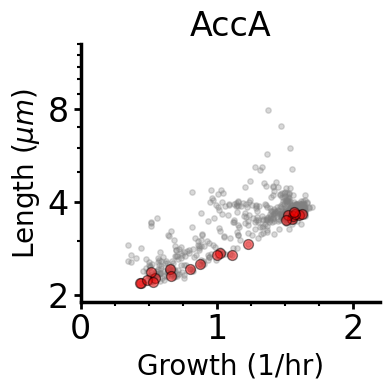

In [20]:
gene_name = "accA"

fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1,1,1)

genes_in_category_wo_target = list(set(target_gene_list)-set([gene_name]))
selected_points = lipid_estimators_df[lipid_estimators_df["Gene"] == gene_name]

xrange = np.linspace(0,2.2)

ax.scatter(selected_points["Instantaneous Growth Rate: Volume"],selected_points["Length"],edgecolors='black',alpha=0.5,\
                       s=50,zorder=-9,color="red")
ax.scatter(lipid_estimators_df["Instantaneous Growth Rate: Volume"],lipid_estimators_df["Length"],\
           edgecolors=None,alpha=0.3,s=15,zorder=-11,color="grey")
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,13)
ax.set_yscale("log",base=2)
ax.set_yticks(ticks=[2,4,8],labels=["2","4","8"],minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_title(gene_name[0].capitalize() + gene_name[1:],fontsize=24)
ax.set_xlabel("Growth (1/hr)",fontsize=20)
ax.set_ylabel(r"Length ($\mu m$)",fontsize=20)
sns.despine(right=True,top=True)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S8/" + gene_name + "_Example_Plot.png",transparent=True,dpi=300,bbox_inches="tight")

## Figure S8B and C

#### All Plots

<Figure size 300x300 with 0 Axes>

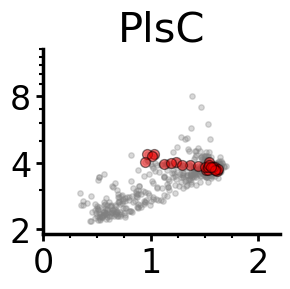

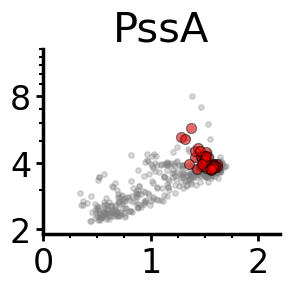

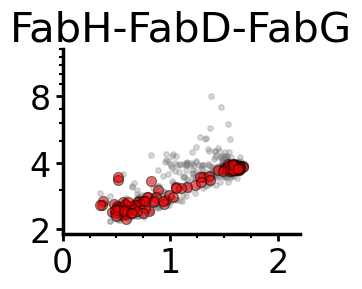

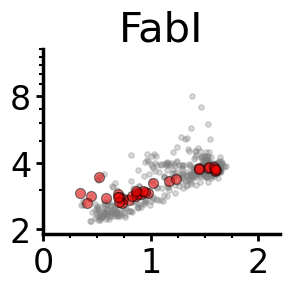

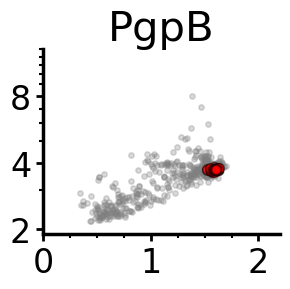

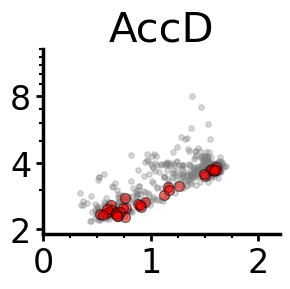

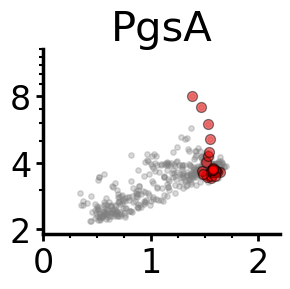

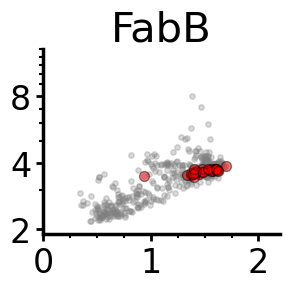

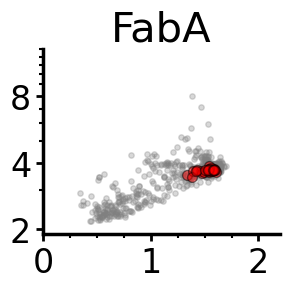

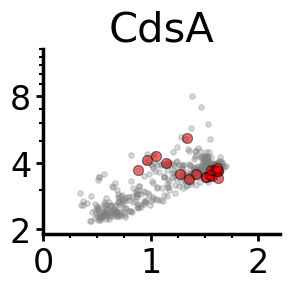

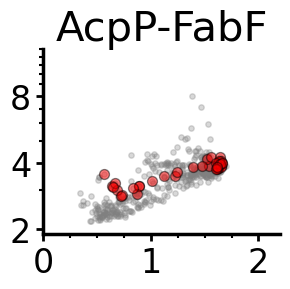

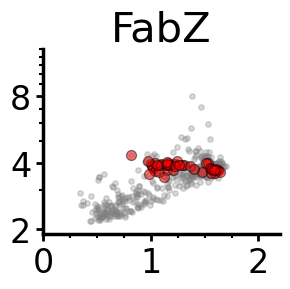

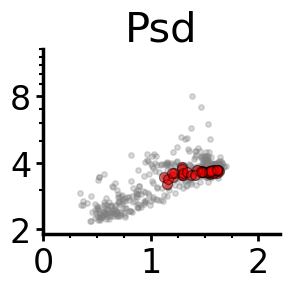

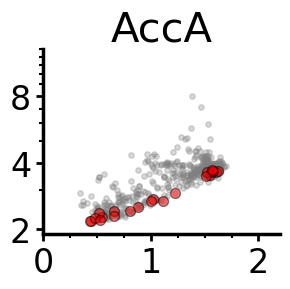

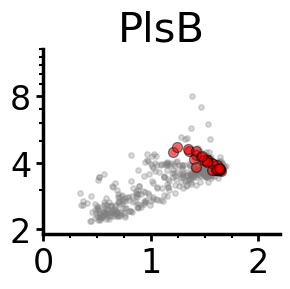

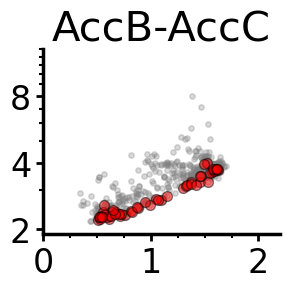

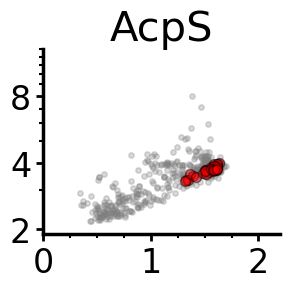

In [21]:
fig = plt.figure(figsize=(3,3))

for i,gene_name in enumerate(target_gene_list):
    fig = plt.figure(figsize=(3,3))
    ax = plt.subplot(1,1,1)
    
    genes_in_category_wo_target = list(set(target_gene_list)-set([gene_name]))
    selected_points = lipid_estimators_df[lipid_estimators_df["Gene"] == gene_name]
    
    xrange = np.linspace(0,2.2)
    
    ax.scatter(selected_points["Instantaneous Growth Rate: Volume"],selected_points["Length"],edgecolors='black',alpha=0.5,\
                           s=50,zorder=-9,color="red")
    ax.scatter(lipid_estimators_df["Instantaneous Growth Rate: Volume"],lipid_estimators_df["Length"],\
               edgecolors=None,alpha=0.3,s=15,zorder=-11,color="grey")
    ax.set_xlim(0,2.2)
    ax.set_ylim(1.9,13)
    ax.set_yscale("log",base=2)
    ax.set_yticks(ticks=[2,4,8],labels=["2","4","8"],minor=False)
    ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
    ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13],labels=[],minor=True)
    ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
    ax.tick_params(axis='both', direction='out', labelsize=24,  width=2, length=5)
    ax.tick_params(axis='both', direction='out', labelsize=24,  width=1.5, which='minor', length=3)
    ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
    ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
    ax.set_title(gene_name[0].capitalize() + gene_name[1:],fontsize=30)
    # ax.set_xlabel("Growth (1/hr)",fontsize=16)
    # ax.set_ylabel(r"Length ($\mu m$)",fontsize=16)
    sns.despine(right=True,top=True)
    plt.tight_layout()
    plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S8/" + gene_name + ".png",transparent=True,dpi=300,bbox_inches="tight")

## Figure S8D

In [22]:
lpx_pathway = ['lpxA','lpxC','lpxD','lpxH','lpxB','lpxK','waaA','waaC','waaF']
lpx_estimators_df = ss_estimators_df[ss_estimators_df["Gene"].isin(lpx_pathway)]
target_gene_list = list(lpx_estimators_df["Gene"].unique())

#### Single Example Plot

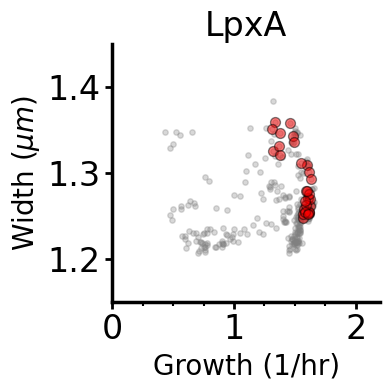

In [23]:
gene_name = "lpxA"

fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1,1,1)

genes_in_category_wo_target = list(set(target_gene_list)-set([gene_name]))
selected_points = lpx_estimators_df[lpx_estimators_df["Gene"] == gene_name]

xrange = np.linspace(0,2.2)

ax.scatter(selected_points["Instantaneous Growth Rate: Volume"],selected_points["Width"],edgecolors='black',alpha=0.5,\
                       s=50,zorder=-9,color="red")
ax.scatter(lpx_estimators_df["Instantaneous Growth Rate: Volume"],lpx_estimators_df["Width"],\
           edgecolors=None,alpha=0.3,s=15,zorder=-11,color="grey")
ax.set_xlim(0,2.2)
ax.set_ylim(1.15,1.45)
# ax.set_yscale("log",base=2)
ax.set_yticks(ticks=[1.2,1.3,1.4],labels=["1.2","1.3","1.4"],minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)

ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_title(gene_name[0].capitalize() + gene_name[1:],fontsize=24)
ax.set_xlabel("Growth (1/hr)",fontsize=20)
ax.set_ylabel(r"Width ($\mu m$)",fontsize=20)
sns.despine(right=True,top=True)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S8/" + gene_name + "_Width_Example_Plot.png",transparent=True,dpi=300,bbox_inches="tight")

## Figure S8E

<Figure size 300x300 with 0 Axes>

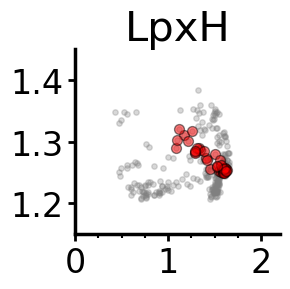

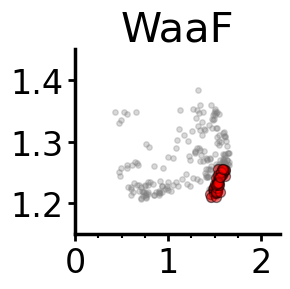

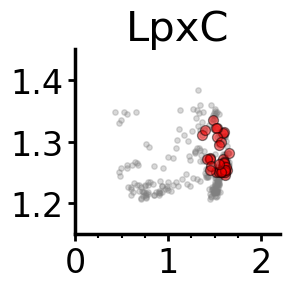

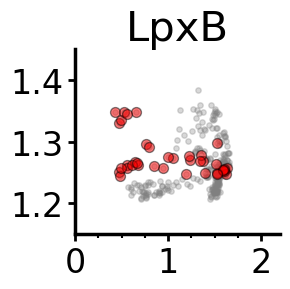

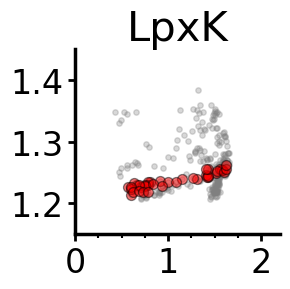

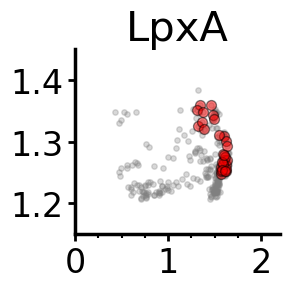

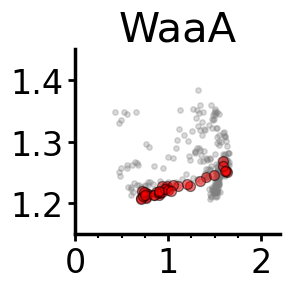

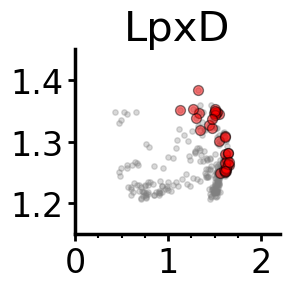

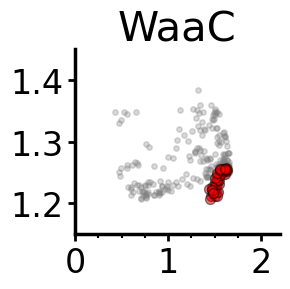

In [24]:
fig = plt.figure(figsize=(3,3))

for i,gene_name in enumerate(target_gene_list):
    fig = plt.figure(figsize=(3,3))
    ax = plt.subplot(1,1,1)
    
    genes_in_category_wo_target = list(set(target_gene_list)-set([gene_name]))
    selected_points = lpx_estimators_df[lpx_estimators_df["Gene"] == gene_name]
    
    xrange = np.linspace(0,2.2)
    
    ax.scatter(selected_points["Instantaneous Growth Rate: Volume"],selected_points["Width"],edgecolors='black',alpha=0.5,\
                           s=50,zorder=-9,color="red")
    ax.scatter(lpx_estimators_df["Instantaneous Growth Rate: Volume"],lpx_estimators_df["Width"],\
               edgecolors=None,alpha=0.3,s=15,zorder=-11,color="grey")
    ax.set_xlim(0,2.2)
    ax.set_ylim(1.15,1.45)
    # ax.set_yscale("log",base=2)
    ax.set_yticks(ticks=[1.2,1.3,1.4],labels=["1.2","1.3","1.4"],minor=False)
    ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
    
    ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
    ax.tick_params(axis='both', direction='out', labelsize=24,  width=2, length=5)
    ax.tick_params(axis='both', direction='out', labelsize=24,  width=1.5, which='minor', length=3)
    ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
    ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
    ax.set_title(gene_name[0].capitalize() + gene_name[1:],fontsize=30)
    # ax.set_xlabel("Growth (1/hr)",fontsize=16)
    # ax.set_ylabel(r"Length ($\mu m$)",fontsize=16)
    sns.despine(right=True,top=True)
    plt.tight_layout()
    plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S8/" + gene_name + "_Width.png",transparent=True,dpi=300,bbox_inches="tight")